In [1]:
from growing_instability_lib import *

Using TensorFlow backend.


In [2]:
sample_sub = pd.read_csv('../data/sampleSubmission.csv')
topics = sorted(set(sample_sub.columns.difference(['id'])))

topic2actual = {}
for i in sample_sub.columns:
    if 'id' == i:
        continue
    topic2actual[i] = segment(i)
    
target_columns = sorted(topics)
len(topics)

160

In [4]:
%%time
wvec_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'wvec_trainingX')
fvec_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'fvec_trainingX')

tfidf_wvec_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'tfidf_wvec_trainingX')
tfidf_fvec_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'tfidf_fvec_trainingX')
tfidf_lsi_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'tfidf_lsi_trainingX')

word2idx_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'word2idx_trainingX')
_word2idx = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', '_word2idx')
trainingY = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'trainingY')

CPU times: user 10.2 s, sys: 4.21 s, total: 14.4 s
Wall time: 18.1 s


In [5]:
# https://192.168.1.25:9999/notebooks/kaggle/data-science-challenge-growing-instability-05-13-2017/src/Topic%20Modeling%20and%20Clustering.ipynb
train_test_df = pd.read_hdf('train_test_df_3.hdf', 'train_test_df')

In [6]:
def transform_topics(df, topics):
    topics = sorted(topics)
#     v = np.zeros(shape=(df.shape[0], len(topics)))
    v = []
    for ix, tp in enumerate(df.topics):
        tt = []
        for t in tp:
            tt.append(topics.index(t))
#             v[ix][topics.index(t)] = 1
        v.append(tt)

    return pd.Series(v, index=df.index)

In [16]:
train_test_word_indices, train_test_wvec, train_test_fvec, train_test_tfidf_wvec, train_test_tfidf_fvec, train_test_tfidf_lsi = extract_features_for(
    train_test_df
)

train_test_y = transform_topics(train_test_df, topics)

Computing fs features...
Current batch in main thread: 102
Current batch in main thread: 221
Computing wv features...
Current batch in main thread: 102
Current batch in main thread: 221
Mapping word indices...
Computing tfidf fs features...
Current batch in main thread: 102
Current batch in main thread: 221
Computing tfidf wv features...
Current batch in main thread: 102
Current batch in main thread: 221
Computing tfidf lsi features...
Current batch in main thread: 102
Current batch in main thread: 221


In [17]:
%%time
ind2word = {j:i for i, j in _word2idx.iteritems()}
ind2class = dict(enumerate(topics))
class2ind = {j: i for i, j in ind2class.items()}

num_samples = trainingY.shape[0]

# ---------------------------------
training_X = word2idx_trainingX.head(num_samples)
training_Y = pd.DataFrame(zip(*np.where(trainingY.head(num_samples) == 1)), columns=['iloc', 'topics'])

training_WV = wvec_trainingX.head(num_samples)
training_FS = fvec_trainingX.head(num_samples)

training_tfidf_WV = tfidf_wvec_trainingX.head(num_samples)
training_tfidf_FS = tfidf_fvec_trainingX.head(num_samples)
training_tfidf_LSI = tfidf_lsi_trainingX.head(num_samples)
# ---------------------------------


# ---------------------------------
training_Y = training_Y.groupby('iloc')['topics'].apply(list)
training_Y.index = trainingY.head(num_samples).index

indices = sorted(training_Y.index[training_Y.index.str.contains('^201[0-9]')])
# np.random.shuffle(indices)
indices = pd.Index(indices)
# ---------------------------------


# ---------------------------------
training_X = training_X.ix[indices]
training_Y = training_Y.ix[indices]

training_WV = training_WV.ix[indices]
training_FS = training_FS.ix[indices]

training_tfidf_WV = training_tfidf_WV.ix[indices]
training_tfidf_FS = training_tfidf_FS.ix[indices]
training_tfidf_LSI = training_tfidf_LSI.ix[indices]
# ---------------------------------

CPU times: user 11.3 s, sys: 252 ms, total: 11.6 s
Wall time: 11.5 s


In [18]:
%%time
wv_sc = StandardScaler()
fs_sc = StandardScaler()

tfidf_wv_sc = StandardScaler()
tfidf_fs_sc = StandardScaler()
tfidf_lsi_sc = StandardScaler()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.06 µs


In [19]:
%%time

from keras.preprocessing import sequence
maxlen = 500


def build_target(y, size):
    e = np.zeros(size)
    e[y] = 1
    return e


def build_input_output_data(X, WV, FS, TWV, TFS, TLSI, Y, maxlen):
    x = sequence.pad_sequences(X, maxlen=maxlen)
    y = np.vstack(Y.map(lambda x: build_target(x, len(topics))))

    wv = np.vstack(WV)
    fs = np.vstack(FS)

    twv = np.vstack(TWV)
    tfs = np.vstack(TFS)
    tlsi = np.vstack(TLSI)

    return x, wv, fs, twv, tfs, tlsi, y


# ---------------------------------
train_ix = training_Y.index.str.contains('^201[2-4]')
val_ix = training_Y.index.str.contains('^2014[b]')
# ---------------------------------


# ---------------------------------
x_train, wv_train, fs_train, tfidf_wv_train, tfidf_fs_train, tfidf_lsi_train, y_train = build_input_output_data(
    training_X.ix[train_ix],

    training_WV.ix[train_ix],
    training_FS.ix[train_ix],

    training_tfidf_WV.ix[train_ix],
    training_tfidf_FS.ix[train_ix],
    training_tfidf_LSI.ix[train_ix],

    training_Y.ix[train_ix],
    maxlen=maxlen
)
# ---------------------------------


# ---------------------------------
x_val, wv_val, fs_val, tfidf_wv_val, tfidf_fs_val, tfidf_lsi_val, y_val = build_input_output_data(
    training_X.ix[val_ix],

    training_WV.ix[val_ix],
    training_FS.ix[val_ix],

    training_tfidf_WV.ix[val_ix],
    training_tfidf_FS.ix[val_ix],
    training_tfidf_LSI.ix[val_ix],

    training_Y.ix[val_ix],
    maxlen=maxlen
)
# ---------------------------------

CPU times: user 1.99 s, sys: 64 ms, total: 2.06 s
Wall time: 2.05 s


In [20]:
# ---------------------------------
train_test_x_train, train_test_wv_train, train_test_fs_train, train_test_tfidf_wv_train, train_test_tfidf_fs_train, train_test_tfidf_lsi_train, train_test_y_train = build_input_output_data(
    train_test_word_indices,

    train_test_wvec,
    train_test_fvec,

    train_test_tfidf_wvec,
    train_test_tfidf_fvec,
    train_test_tfidf_lsi,

    train_test_y,
    maxlen=maxlen
)
# ---------------------------------

In [21]:
def upsample(x, N=3):
    return np.vstack([x for i in xrange(N)])

In [22]:
x_train = np.vstack([x_train, upsample(train_test_x_train)])

wv_train = np.vstack([wv_train, upsample(train_test_wv_train)])
fs_train = np.vstack([fs_train, upsample(train_test_fs_train)])

tfidf_wv_train = np.vstack([tfidf_wv_train, upsample(train_test_tfidf_wv_train)])
tfidf_fs_train = np.vstack([tfidf_fs_train, upsample(train_test_tfidf_fs_train)])
tfidf_lsi_train = np.vstack([tfidf_lsi_train, upsample(train_test_tfidf_lsi_train)])

y_train = np.vstack([y_train, upsample(train_test_y_train)])

In [23]:
# ---------------------------------
wv_train = wv_sc.fit_transform(wv_train)
fs_train = fs_sc.fit_transform(fs_train)

tfidf_wv_train = tfidf_wv_sc.fit_transform(tfidf_wv_train)
tfidf_fs_train = tfidf_fs_sc.fit_transform(tfidf_fs_train)
tfidf_lsi_train = tfidf_lsi_sc.fit_transform(tfidf_lsi_train)
# ---------------------------------


# ---------------------------------
wv_val = wv_sc.transform(wv_val)
fs_val = fs_sc.transform(fs_val)

tfidf_wv_val = tfidf_wv_sc.transform(tfidf_wv_val)
tfidf_fs_val = tfidf_fs_sc.transform(tfidf_fs_val)
tfidf_lsi_val = tfidf_lsi_sc.transform(tfidf_lsi_val)
# ---------------------------------

In [24]:
training_Y.shape, training_Y.ix[training_Y.index.str.contains('^2014[b]')].shape

((94731,), (9424,))

In [26]:
q = pd.DataFrame(y_train, columns=topics).sum()  #, index=training_Y.ix[train_ix].index).sum()

In [28]:
q[q > 0]

afghanistan                              1430.0
aid                                      1179.0
algerianhostagecrisis                      58.0
alqaida                                   641.0
alshabaab                                 116.0
antiwar                                    10.0
arabandmiddleeastprotests                1474.0
armstrade                                 239.0
australianguncontrol                        3.0
australiansecurityandcounterterrorism      92.0
bastilledaytruckattack                     21.0
belgium                                   118.0
berlinchristmasmarketattack                15.0
bigdata                                   141.0
biometrics                                 22.0
bokoharam                                 172.0
bostonmarathonbombing                     178.0
britisharmy                               226.0
brusselsattacks                            45.0
cameroon                                   46.0
carers                                  

In [29]:
import tensorflow as K
import keras.backend as KB


def f1_micro(y_true, y_pred):
    TP = K.metrics.true_positives(y_true, K.round(y_pred))
    FP = K.metrics.false_positives(y_true, K.round(y_pred))
    FN = K.metrics.false_negatives(y_true, K.round(y_pred))
    
    p = K.reduce_sum(TP) / (K.reduce_sum(TP) + K.reduce_sum(FP))
    r = K.reduce_sum(TP) / (K.reduce_sum(TP) + K.reduce_sum(FN))
    
    return (2.0 * p * r) / (p + r)


def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = KB.sum(KB.round(KB.clip(y_true * y_pred, 0, 1)))
    c2 = KB.sum(KB.round(KB.clip(y_pred, 0, 1)))
    c3 = KB.sum(KB.round(KB.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [30]:
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, Convolution1D, MaxPooling1D, Flatten
from keras.models import Model
import itertools as it


def build_deep_input_stack(input_node):
    x = Dense(128, activation='tanh')(input_node)
    x = Dropout(0.1)(x)
    x = Dense(256, activation='relu')(input_node)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.1)(x)
    return x


def entangle_inputs(input_nodes=[]):
    assert(len(input_nodes) > 1)
    
    entangled_inputs = []

    for n1, n2 in it.combinations(input_nodes, 2):
        entangled_inputs.append(
            keras.layers.dot([n1, n2], 1, normalize=True)
        )
    
    return entangled_inputs


wv_input = Input(shape=(300,), name='wv_input')
fs_input = Input(shape=(300,), name='fs_input')

tfidf_wv_input = Input(shape=(300,), name='tfidf_wv_input')
tfidf_fs_input = Input(shape=(300,), name='tfidf_fs_input')
tfidf_lsi_input = Input(shape=(300,), name='tfidf_lsi_input')


wv_x = build_deep_input_stack(wv_input)
fs_x = build_deep_input_stack(fs_input)
tfidf_wv_x = build_deep_input_stack(tfidf_wv_input)
tfidf_fs_x = build_deep_input_stack(tfidf_fs_input)
tfidf_lsi_x = build_deep_input_stack(tfidf_wv_input)

stacked_inputs_x = [wv_x, fs_x, tfidf_wv_x, tfidf_fs_x, tfidf_lsi_x]
# stacked_inputs_x = [tfidf_wv_x, tfidf_fs_x, tfidf_lsi_x]
entangled_inputs_x = entangle_inputs(stacked_inputs_x)

x = keras.layers.concatenate(stacked_inputs_x + entangled_inputs_x)

# We stack a deep densely-connected network on top
x = Dense(128, activation='tanh')(x)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)

# And finally we add the main logistic regression layer
main_output = Dense(len(class2ind), activation='sigmoid', name='main_output')(x)

model = Model(
    inputs=[
        wv_input,
        fs_input,
        tfidf_wv_input,
        tfidf_fs_input,
        tfidf_lsi_input,
    ],
    outputs=[main_output]
)

In [31]:
entangled_inputs_x

[<tf.Tensor 'dot_1/ExpandDims:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dot_2/ExpandDims:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dot_3/ExpandDims:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dot_4/ExpandDims:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dot_5/ExpandDims:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dot_6/ExpandDims:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dot_7/ExpandDims:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dot_8/ExpandDims:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dot_9/ExpandDims:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dot_10/ExpandDims:0' shape=(?, 1) dtype=float32>]

In [32]:
model.compile(
    optimizer='rmsprop',  # keras.optimizers.RMSprop(lr=0.005),  # , rho=0.9, epsilon=1e-08, decay=0.0, clipnorm=1),
    loss={'main_output': 'categorical_crossentropy'},
    loss_weights={'main_output': 1.},
    metrics=['accuracy', f1_micro]
)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
wv_input (InputLayer)            (None, 300)           0                                            
____________________________________________________________________________________________________
fs_input (InputLayer)            (None, 300)           0                                            
____________________________________________________________________________________________________
tfidf_wv_input (InputLayer)      (None, 300)           0                                            
____________________________________________________________________________________________________
tfidf_fs_input (InputLayer)      (None, 300)           0                                            
___________________________________________________________________________________________

In [22]:
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=2)
# model.fit(X, y, validation_split=0.2, callbacks=[early_stopping])

In [33]:
def build_training_inputs(wv, fs, tfidf_wv, tfidf_fs, tfidf_lsi):
    training_inputs = {
        'wv_input': wv,
        'fs_input': fs,
        'tfidf_wv_input': tfidf_wv,
        'tfidf_fs_input': tfidf_fs,
        'tfidf_lsi_input': tfidf_lsi,
    }
    
    return training_inputs
    

training_inputs = build_training_inputs(
    wv_train,
    fs_train,
    tfidf_wv_train,
    tfidf_fs_train,
    tfidf_lsi_train,
)

training_outputs = {
    'main_output': y_train,
}

# train_test_shape = train_test_df.shape[0]
# train_test_training_inputs = build_training_inputs(
#     wv_train[-train_test_shape:],
#     fs_train[-train_test_shape:],
#     tfidf_wv_train[-train_test_shape:],
#     tfidf_fs_train[-train_test_shape:],
#     tfidf_lsi_train[-train_test_shape:],
# )

# train_test_training_outputs = {
#     'main_output': y_train[-train_test_shape:],
# }


validation_data=(
    build_training_inputs(
        wv_val,
        fs_val,
        tfidf_wv_val,
        tfidf_fs_val,
        tfidf_lsi_val,
    ),
    {
        'main_output': y_val,
    }
)

In [24]:
%%time
# And trained it via:
batch_size = 1000
epochs = 100

hist = model.fit(
    training_inputs,
    training_outputs,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    validation_data=validation_data,
)

Train on 56877 samples, validate on 9424 samples
Epoch 1/100
56877/56877 [==============================] - 2s - loss: 5.6404 - acc: 0.1295 - f1_micro: 0.0630 - val_loss: 4.1946 - val_acc: 0.3277 - val_f1_micro: 0.0990
Epoch 2/100
56877/56877 [==============================] - 1s - loss: 3.7813 - acc: 0.4165 - f1_micro: 0.1261 - val_loss: 3.1512 - val_acc: 0.5209 - val_f1_micro: 0.1516
Epoch 3/100
56877/56877 [==============================] - 1s - loss: 3.1480 - acc: 0.5158 - f1_micro: 0.1753 - val_loss: 2.7997 - val_acc: 0.5892 - val_f1_micro: 0.1980
Epoch 4/100
56877/56877 [==============================] - 1s - loss: 2.8541 - acc: 0.5558 - f1_micro: 0.2187 - val_loss: 2.6495 - val_acc: 0.5999 - val_f1_micro: 0.2385
Epoch 5/100
56877/56877 [==============================] - 1s - loss: 2.6869 - acc: 0.5808 - f1_micro: 0.2566 - val_loss: 2.5518 - val_acc: 0.6065 - val_f1_micro: 0.2741
Epoch 6/100
56877/56877 [==============================] - 1s - loss: 2.5511 - acc: 0.5954 - f1_micro

56877/56877 [==============================] - 1s - loss: 1.3139 - acc: 0.7469 - f1_micro: 0.7472 - val_loss: 1.1294 - val_acc: 0.7915 - val_f1_micro: 0.7478
Epoch 96/100
56877/56877 [==============================] - 1s - loss: 1.3169 - acc: 0.7473 - f1_micro: 0.7484 - val_loss: 1.1351 - val_acc: 0.7910 - val_f1_micro: 0.7489
Epoch 97/100
56877/56877 [==============================] - 1s - loss: 1.3075 - acc: 0.7506 - f1_micro: 0.7495 - val_loss: 1.1346 - val_acc: 0.7899 - val_f1_micro: 0.7501
Epoch 98/100
56877/56877 [==============================] - 1s - loss: 1.3036 - acc: 0.7492 - f1_micro: 0.7506 - val_loss: 1.1241 - val_acc: 0.7971 - val_f1_micro: 0.7512
Epoch 99/100
56877/56877 [==============================] - 1s - loss: 1.3050 - acc: 0.7491 - f1_micro: 0.7517 - val_loss: 1.1459 - val_acc: 0.7855 - val_f1_micro: 0.7523
Epoch 100/100
56877/56877 [==============================] - 1s - loss: 1.3031 - acc: 0.7482 - f1_micro: 0.7528 - val_loss: 1.1262 - val_acc: 0.7870 - val_f1_

In [36]:
%%time
# And trained it via:
batch_size = 1000
epochs = 100

hist = model.fit(
    training_inputs,
    training_outputs,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    validation_data=validation_data,
)

Train on 57243 samples, validate on 9424 samples
Epoch 1/100
57243/57243 [==============================] - 1s - loss: 1.2080 - acc: 0.7683 - f1_micro: 0.8133 - val_loss: 1.0572 - val_acc: 0.8016 - val_f1_micro: 0.8135
Epoch 2/100
57243/57243 [==============================] - 1s - loss: 1.2059 - acc: 0.7668 - f1_micro: 0.8137 - val_loss: 1.0453 - val_acc: 0.8065 - val_f1_micro: 0.8139
Epoch 3/100
57243/57243 [==============================] - 1s - loss: 1.2065 - acc: 0.7687 - f1_micro: 0.8141 - val_loss: 1.0555 - val_acc: 0.8072 - val_f1_micro: 0.8142
Epoch 4/100
57243/57243 [==============================] - 1s - loss: 1.2085 - acc: 0.7660 - f1_micro: 0.8144 - val_loss: 1.0707 - val_acc: 0.8053 - val_f1_micro: 0.8146
Epoch 5/100
57243/57243 [==============================] - 1s - loss: 1.2048 - acc: 0.7692 - f1_micro: 0.8148 - val_loss: 1.0500 - val_acc: 0.8007 - val_f1_micro: 0.8150
Epoch 6/100
57243/57243 [==============================] - 1s - loss: 1.2051 - acc: 0.7678 - f1_micro

57243/57243 [==============================] - 1s - loss: 1.1954 - acc: 0.7709 - f1_micro: 0.8284 - val_loss: 1.0513 - val_acc: 0.8053 - val_f1_micro: 0.8285
Epoch 49/100
57243/57243 [==============================] - 1s - loss: 1.1933 - acc: 0.7710 - f1_micro: 0.8287 - val_loss: 1.0414 - val_acc: 0.8044 - val_f1_micro: 0.8288
Epoch 50/100
57243/57243 [==============================] - 1s - loss: 1.1954 - acc: 0.7713 - f1_micro: 0.8289 - val_loss: 1.0426 - val_acc: 0.8121 - val_f1_micro: 0.8291
Epoch 51/100
57243/57243 [==============================] - 1s - loss: 1.1902 - acc: 0.7701 - f1_micro: 0.8292 - val_loss: 1.0504 - val_acc: 0.8054 - val_f1_micro: 0.8293
Epoch 52/100
57243/57243 [==============================] - 1s - loss: 1.1941 - acc: 0.7728 - f1_micro: 0.8295 - val_loss: 1.0330 - val_acc: 0.8084 - val_f1_micro: 0.8296
Epoch 53/100
57243/57243 [==============================] - 1s - loss: 1.1895 - acc: 0.7703 - f1_micro: 0.8297 - val_loss: 1.0345 - val_acc: 0.8003 - val_f1_m

57243/57243 [==============================] - 1s - loss: 1.1912 - acc: 0.7728 - f1_micro: 0.8393 - val_loss: 1.0431 - val_acc: 0.8130 - val_f1_micro: 0.8394
Epoch 96/100
57243/57243 [==============================] - 1s - loss: 1.1864 - acc: 0.7742 - f1_micro: 0.8395 - val_loss: 1.0557 - val_acc: 0.8089 - val_f1_micro: 0.8396
Epoch 97/100
57243/57243 [==============================] - 1s - loss: 1.1904 - acc: 0.7709 - f1_micro: 0.8397 - val_loss: 1.0453 - val_acc: 0.8103 - val_f1_micro: 0.8398
Epoch 98/100
57243/57243 [==============================] - 1s - loss: 1.1836 - acc: 0.7731 - f1_micro: 0.8399 - val_loss: 1.0549 - val_acc: 0.8192 - val_f1_micro: 0.8400
Epoch 99/100
57243/57243 [==============================] - 1s - loss: 1.1900 - acc: 0.7718 - f1_micro: 0.8401 - val_loss: 1.0542 - val_acc: 0.8104 - val_f1_micro: 0.8402
Epoch 100/100
57243/57243 [==============================] - 1s - loss: 1.1861 - acc: 0.7720 - f1_micro: 0.8403 - val_loss: 1.0329 - val_acc: 0.8063 - val_f1_

In [ ]:
# %%time
# # And trained it via:
# batch_size = 10
# epochs = 50

# hist = model.fit(
#     train_test_training_inputs,
#     train_test_training_outputs,
#     epochs=epochs,
#     batch_size=batch_size,
#     validation_split=0.2,
#     validation_data=validation_data,
# )

In [37]:
hist.history['f1_micro'][-1]

0.84033768880776072

In [38]:
# %%time
# log_history_file = 'lstm-word2vec-fasttext-lsi.epoch.csv'
# model_name = 'models/tfidf-wv-fs-lsi-2010-2014-data_cat-crossentropy-2014-b-val-sc_tfidf_wv_fs_lsi.model'
# batch_size = 1200
# epochs = 5
# total_epochs = 100

# for i in xrange(0, total_epochs // epochs):
#     hist = model.fit(
#         training_inputs,
#         training_outputs,
#         epochs=epochs,
#         batch_size=batch_size,
#         validation_split=0.2,
#         validation_data=validation_data,
#     )

#     model.save(model_name.format(i))
#     print
#     print('Done with epoch: {}'.format((i + 1) * epochs))
#     with open(log_history_file, 'a') as fl:
#         fl.write(model_name + '\n')
#         fl.write('Epoch {}\n'.format((i + 1) * epochs))
#         fl.write('{}\n'.format(datetime.now()))
#         fl.write('\n'.join(['{}: {}'.format(k, v[0]) for k, v in hist.history.items()]))
#         fl.write('\n\n')
#     print

In [39]:
# %%time
# total_epochs = 100
# for j in xrange(i, i + (total_epochs // epochs)):
#     hist = model.fit(
#         training_inputs,
#         training_outputs,
#         epochs=epochs,
#         batch_size=batch_size,
#         validation_split=0.2,
#         validation_data=validation_data,
#     )

#     model.save(model_name.format(i))
#     print
#     print('Done with epoch: {}'.format((j + 1) * epochs))
#     with open(log_history_file, 'a') as fl:
#         fl.write(model_name + '\n')
#         fl.write('Epoch {}\n'.format((j + 1) * epochs))
#         fl.write('{}\n'.format(datetime.now()))
#         fl.write('\n'.join(['{}: {}'.format(k, v[0]) for k, v in hist.history.items()]))
#         fl.write('\n\n')
#     print

In [40]:
# model = keras.models.load_model(
#     'models/lstm-word2vec-fasttext_2010-2014-data_categorical-crossentropy-2014-b-val-standard_scaled_wv_fs.model',
#     custom_objects={'f1_micro': f1_micro}
# )

In [ ]:
train_test_wv_train

In [104]:
i = j

In [41]:
g = model.predict(
    build_training_inputs(
        wv_train,
        fs_train,
        tfidf_wv_train,
        tfidf_fs_train,
        tfidf_lsi_train,
    )
)

In [42]:
g

array([[  2.20138209e-15,   2.42166287e-08,   1.41483841e-15, ...,
          1.19395740e-14,   8.71162044e-22,   5.17794256e-14],
       [  8.68130334e-21,   4.66071462e-16,   2.03802076e-22, ...,
          3.22669669e-23,   9.73546685e-23,   1.42461977e-37],
       [  2.24891386e-23,   1.92595978e-18,   7.91063942e-19, ...,
          1.00835154e-21,   2.09687485e-30,   4.72186983e-36],
       ..., 
       [  5.87631423e-18,   5.57505770e-17,   7.04986763e-11, ...,
          5.10007049e-28,   1.99941725e-15,   7.01880515e-01],
       [  1.73102794e-19,   3.80870466e-20,   3.55734973e-12, ...,
          2.98159203e-29,   1.81713713e-17,   7.62282670e-01],
       [  6.64151811e-16,   2.43986888e-16,   3.74290332e-09, ...,
          3.50970149e-23,   2.64689902e-11,   9.47064757e-01]], dtype=float32)

In [43]:
from sklearn.metrics import f1_score as sk_f1_score

In [44]:
%%time
dt = 0.01
s = 0.1
e = 0.6
th = np.arange(s, e + dt, dt)
mean_fscores = []
for t in th:
#     fscores = []
#     for ix in range(g.shape[0]):
#         y_a = y_train[ix]
#         y_p = 1.0 * (g[ix] > t)
#         fscores.append(sk_f1_score(y_a, y_p))
#     mean_fscores.append(np.mean(fscores))
    %time mean_fscores.append((t, sk_f1_score(y_train, 1.0 * (g > t), average='micro')))

CPU times: user 436 ms, sys: 36 ms, total: 472 ms
Wall time: 472 ms
CPU times: user 468 ms, sys: 40 ms, total: 508 ms
Wall time: 503 ms
CPU times: user 456 ms, sys: 40 ms, total: 496 ms
Wall time: 494 ms
CPU times: user 432 ms, sys: 44 ms, total: 476 ms
Wall time: 471 ms
CPU times: user 448 ms, sys: 44 ms, total: 492 ms
Wall time: 490 ms
CPU times: user 496 ms, sys: 36 ms, total: 532 ms
Wall time: 530 ms
CPU times: user 436 ms, sys: 64 ms, total: 500 ms
Wall time: 499 ms
CPU times: user 416 ms, sys: 56 ms, total: 472 ms
Wall time: 468 ms
CPU times: user 440 ms, sys: 36 ms, total: 476 ms
Wall time: 469 ms
CPU times: user 428 ms, sys: 44 ms, total: 472 ms
Wall time: 470 ms
CPU times: user 432 ms, sys: 44 ms, total: 476 ms
Wall time: 470 ms
CPU times: user 432 ms, sys: 40 ms, total: 472 ms
Wall time: 469 ms
CPU times: user 448 ms, sys: 24 ms, total: 472 ms
Wall time: 469 ms
CPU times: user 440 ms, sys: 32 ms, total: 472 ms
Wall time: 469 ms
CPU times: user 416 ms, sys: 56 ms, total: 472 m

In [45]:
thresh, thresh_score = sorted(mean_fscores, key=lambda x: x[1], reverse=True)[0]
thresh, thresh_score

(0.53999999999999981, 0.95807753620730596)

In [46]:
thresh

0.53999999999999981

In [47]:
# train_test_df.iloc[ix].bodyText

In [57]:
topics[22]

'charliehebdoattack'

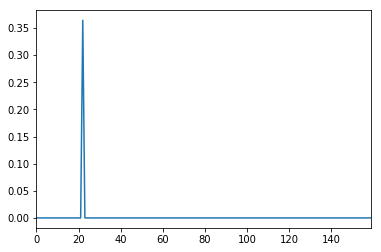

In [72]:
%matplotlib inline
ix = 13
sd = -100
pd.Series(g[sd:][ix]).plot()

In [73]:
# thresh = 0.5
np.where(y_train[sd:][ix] == 1), np.where(g[sd:][ix] > thresh)

((array([22]),), (array([], dtype=int64),))

In [7]:
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.lsimodel import LsiModel
from gensim.corpora import Dictionary

In [8]:
dictionary = TfidfModel.load('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.dictionary')
tfidf = TfidfModel.load('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.tfidf')
lsi = LsiModel.load('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.lsi')

In [9]:
wvmodel = Word2Vec.load('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.w2v.model')

In [10]:
fsmodel = fasttext.load_model('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.fasttext.model.bin')

In [11]:
_fsmodel_cache = {}
def get_fsvec(word):
    if word in _fsmodel_cache:
        fv = _fsmodel_cache[word]
    else:
        fv = fsmodel[word]
        _fsmodel_cache[word] = fv

    return fv

In [12]:
def transform_tfidf_word2vec(tokens, stopwords=[]):
#     global wvmodel
#     global tfidf
    # This requires wvmodel to be present in the namespace.
    wv_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords and w in wvmodel.wv.vocab)]
    ).map(
        lambda x: tfidf[dictionary.doc2bow(x)]
    ).map(
        lambda x: np.array([wvmodel[dictionary.id2token[id]] * w for id, w in x]).mean(axis=0) if len(x) > 0 else np.nan
    )

    return wv_feature_vec


def transform_tfidf_fasttext(tokens, stopwords=[]):
#     global fsmodel
#     global tfidf
    # This requires wvmodel to be present in the namespace.
    fs_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords)]
    ).map(
        lambda x: tfidf[dictionary.doc2bow(x)]
    ).map(
        lambda x: np.array([np.array(get_fsvec(dictionary.id2token[id])) * w for id, w in x]).mean(axis=0) if len(x) > 0 else np.nan
    )

    return fs_feature_vec


def build_lsi_vector(l):
    v = np.zeros(lsi.num_topics)
    
    for ix, vv in lsi[tfidf[dictionary.doc2bow(l)]]:
        v[ix] = vv
        
    return v


def transform_tfidf_lsi(tokens, stopwords=[]):
#     global fsmodel
#     global tfidf
    # This requires wvmodel to be present in the namespace.
    lsi_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords)]
    ).map(
        lambda x: build_lsi_vector(x) if len(x) > 0 else np.nan
    )

    return lsi_feature_vec


def transform_fasttext(tokens, stopwords=[]):
    global fsmodel
    # This requires fsmodel to be present in the namespace.
    fs_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords)]
    ).map(lambda x: np.array([get_fsvec(w) for w in x]).mean(axis=0) if len(x) > 0 else np.nan)

    return fs_feature_vec


def transform_unsupervised_sentiment_neuron(tokens, stopwords=[]):
    # This requires fsmodel to be present in the namespace.
    
    usn_feature_vec = usnmodel.transform(tokens)

    # usn_feature_vec = tokens.map(
    #     lambda x: [w for w in x.split() if (w not in stopwords)]
    # ).map(lambda x: np.array([usnmodel[w] for w in x]).mean(axis=0) if len(x) > 0 else np.nan)

    return usn_feature_vec


def transform_word2vec(tokens, stopwords=[]):
    global wvmodel
    # This requires wvmodel to be present in the namespace.
    wv_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords and w in wvmodel.wv.vocab)]
    ).map(lambda x: np.array([wvmodel[w] for w in x]).mean(axis=0) if len(x) > 0 else np.nan)

    return wv_feature_vec


def parallel_generate_word_vectors(samp, transformer, stopwords, batch, num_proc):
    with Parallel(n_jobs=num_proc) as parallel:
        dataset = []
        is_break = False
        i = 0

        while not is_break:
            payload = []

            for j in xrange(num_proc):
                t_df = samp[(i + j) * batch: (i + 1 + j) * batch]

                if t_df.empty:
                    is_break = True
                    continue

                payload.append(
                    delayed(transformer)(
                        t_df, stopwords
                    )
                )

            print('Current batch in main thread: {}'.format((i + j) * batch))

            if payload:
                results = parallel(payload)
                dataset.extend(results)
                i += num_proc

    return pd.concat(dataset)


In [13]:
def get_classes(pred, scale_param=0.75, min_thresh=0.05, thresh = 0.5):
#     mx = pred.mean() + 3 * pred.std()
    return np.where(pred > thresh)[0]  

In [14]:
def word2idx_transform(word, _word2idx):
    return _word2idx.get(word, 0)


In [15]:
def extract_features_for(df, min_batch=2000, stopwords=[], num_proc=7):
    df_tokens = transform_text(df)
    
    batch = min(df_tokens.shape[0] / num_proc, min_batch)

    print('Computing fs features...')
    fvec = parallel_generate_word_vectors(df_tokens, transform_fasttext, stopwords=stopwords, batch=batch, num_proc=num_proc)

    print('Computing wv features...')
    wvec = parallel_generate_word_vectors(df_tokens, transform_word2vec, stopwords=stopwords, batch=batch, num_proc=num_proc)

    print('Mapping word indices...')
    word_indices = df_tokens.map(lambda x: [word2idx_transform(i, _word2idx) for i in x.split()])

    print('Computing tfidf fs features...')
    tfidf_fvec = parallel_generate_word_vectors(df_tokens, transform_tfidf_fasttext, stopwords=stopwords, batch=batch, num_proc=num_proc)

    print('Computing tfidf wv features...')
    tfidf_wvec = parallel_generate_word_vectors(df_tokens, transform_tfidf_word2vec, stopwords=stopwords, batch=batch, num_proc=num_proc)

    print('Computing tfidf lsi features...')
    tfidf_lsi = parallel_generate_word_vectors(df_tokens, transform_tfidf_lsi, stopwords=stopwords, batch=batch, num_proc=num_proc)
    
    return word_indices, wvec, fvec, tfidf_wvec, tfidf_fvec, tfidf_lsi

In [74]:
with open('../data/TestData.json') as fl:
    data = json.load(fl)
    test_df = pd.DataFrame(data['TestData']).T
    del(data)

In [75]:
%%time
test_word_indices,test_wvec, test_fvec, test_tfidf_wvec, test_tfidf_fvec, test_tfidf_lsi = extract_features_for(
    test_df
)

Computing fs features...
Current batch in main thread: 6498
Current batch in main thread: 14079
Computing wv features...
Current batch in main thread: 6498
Current batch in main thread: 14079
Mapping word indices...
Computing tfidf fs features...
Current batch in main thread: 6498
Current batch in main thread: 14079
Computing tfidf wv features...
Current batch in main thread: 6498
Current batch in main thread: 14079
Computing tfidf lsi features...
Current batch in main thread: 6498
Current batch in main thread: 14079
CPU times: user 52.2 s, sys: 4.41 s, total: 56.6 s
Wall time: 1min 26s


In [76]:
assert(np.all(test_wvec[test_wvec.isnull()].index == test_fvec[test_fvec.isnull()].index))
test_null_index = test_wvec[test_wvec.isnull()].index.union(test_fvec[test_fvec.isnull()].index)

In [77]:
test_null_index

Index([u'TestData_02543', u'TestData_05012', u'TestData_05830'], dtype='object')

In [78]:
%%time
valid_test_index = test_word_indices.index.difference(test_null_index)
x_test = test_word_indices.ix[valid_test_index]  # .map(lambda x: [top_token2ind.get(i, 0) for i in x])

x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

wv_test = np.vstack(test_wvec.ix[valid_test_index])
fs_test = np.vstack(test_fvec.ix[valid_test_index])

tfidf_wv_test = np.vstack(test_tfidf_wvec.ix[valid_test_index])
tfidf_fs_test = np.vstack(test_tfidf_fvec.ix[valid_test_index])
tfidf_lsi_test = np.vstack(test_tfidf_lsi.ix[valid_test_index])

wv_test = wv_sc.transform(wv_test)
fs_test = fs_sc.transform(fs_test)

tfidf_wv_test = tfidf_wv_sc.transform(tfidf_wv_test)
tfidf_fs_test = tfidf_fs_sc.transform(tfidf_fs_test)
tfidf_lsi_test = tfidf_lsi_sc.transform(tfidf_lsi_test)

test_inputs = build_training_inputs(
    wv_test,
    fs_test,
    tfidf_wv_test,
    tfidf_fs_test,
    tfidf_lsi_test,
)

CPU times: user 348 ms, sys: 28 ms, total: 376 ms
Wall time: 377 ms


In [79]:
test_probas = model.predict(test_inputs, batch_size=batch_size)

In [80]:
main_test_probas = test_probas

In [81]:
main_test_probas

array([[  8.45687097e-15,   9.60972482e-11,   6.67067823e-09, ...,
          5.84431115e-11,   2.77209750e-29,   3.90811282e-18],
       [  1.33567311e-13,   6.27112797e-08,   1.08719211e-09, ...,
          1.97126437e-14,   5.12922886e-17,   1.88924263e-17],
       [  2.43227819e-15,   3.15362669e-09,   1.88201641e-14, ...,
          1.26029058e-15,   1.40200144e-25,   1.83297716e-23],
       ..., 
       [  4.72065702e-16,   5.09863137e-04,   3.37027162e-02, ...,
          1.15086081e-23,   4.50472015e-07,   6.16123784e-18],
       [  6.01658376e-11,   7.09882588e-05,   1.47755426e-08, ...,
          4.92415223e-12,   7.81392832e-12,   1.01341055e-14],
       [  5.47104205e-14,   3.48044409e-07,   1.46855018e-06, ...,
          8.50327453e-19,   3.15968544e-19,   3.32763670e-16]], dtype=float32)

In [82]:
skip_index = [int(s.split('_')[1]) - 1 for s in test_null_index]  # Subtract 1 since test index starts at 1 while enumerate starts at 0
skip_index

[2542, 5011, 5829]

In [83]:
main_test_probas.shape, test_df.shape

((7578, 160), (7581, 3))

In [100]:
%%time
# valid_test_feature_vec found below!
thresh = 0.5
test_values = np.zeros([main_test_probas.shape[0], len(topics)])
for ix, pred in enumerate(main_test_probas):
    for v in get_classes(pred, thresh=0.5):
        test_values[ix][v] = 1

test_sub_df = pd.DataFrame(
    test_values,
    index=test_df.ix[test_df.index.difference(test_null_index)].index,
    columns=topics
)

null_test_df = pd.DataFrame(
    np.zeros((len(test_null_index), len(topics))),
    index=test_null_index,
    columns=topics
)

test_sub_df = test_sub_df.append(null_test_df)
test_sub_df = test_sub_df.sort_index()

CPU times: user 28 ms, sys: 4 ms, total: 32 ms
Wall time: 29.7 ms


In [101]:
6552, thresh

(6552, 0.5)

In [102]:
# 9627 (0.5), 14297 (0.3)

In [103]:
test_sub_df.sum().sum()

12803.0

In [104]:
test_sub_df.sum().sum()

12803.0

In [105]:
thresh, test_sub_df.sum().sum()

(0.5, 12803.0)

In [73]:
test_sub_df.sum().sum()

13897.0

In [109]:
test_sub_df.sum().sum()

12489.0

In [133]:
test_word_indices.map(len).describe()

count    7581.000000
mean      882.691070
std       621.585386
min         0.000000
25%       552.000000
50%       770.000000
75%      1026.000000
max      8171.000000
Name: bodyText, dtype: float64

In [134]:
test_word_indices.map(len).quantile(0.9)

1382.0

In [130]:
len(test_df.ix['TestData_04490'].bodyText.split())

1223

In [283]:
test_sub_df.sum()

activism                                    0.0
afghanistan                               112.0
aid                                        80.0
algerianhostagecrisis                      16.0
alqaida                                   109.0
alshabaab                                  39.0
antiwar                                     0.0
arabandmiddleeastprotests                 333.0
armstrade                                  75.0
australianguncontrol                        0.0
australiansecurityandcounterterrorism      63.0
bastilledaytruckattack                     26.0
belgium                                    11.0
berlinchristmasmarketattack                20.0
bigdata                                     7.0
biometrics                                  1.0
bokoharam                                  37.0
bostonmarathonbombing                      61.0
britisharmy                                 0.0
brusselsattacks                            50.0
cameroon                                

In [91]:
test_sub_df.sum()

activism                                    0.0
afghanistan                                95.0
aid                                        89.0
algerianhostagecrisis                      24.0
alqaida                                   136.0
alshabaab                                  38.0
antiwar                                     0.0
arabandmiddleeastprotests                 162.0
armstrade                                  96.0
australianguncontrol                        0.0
australiansecurityandcounterterrorism      39.0
bastilledaytruckattack                     38.0
belgium                                     7.0
berlinchristmasmarketattack                16.0
bigdata                                     6.0
biometrics                                  1.0
bokoharam                                  37.0
bostonmarathonbombing                      51.0
britisharmy                                 4.0
brusselsattacks                            71.0
cameroon                                

In [67]:
test_sub_df.sum()

activism                                    0.0
afghanistan                                96.0
aid                                        70.0
algerianhostagecrisis                      31.0
alqaida                                   151.0
alshabaab                                  35.0
antiwar                                     2.0
arabandmiddleeastprotests                 239.0
armstrade                                  78.0
australianguncontrol                        0.0
australiansecurityandcounterterrorism      79.0
bastilledaytruckattack                      0.0
belgium                                    87.0
berlinchristmasmarketattack                 0.0
bigdata                                     8.0
biometrics                                  2.0
bokoharam                                  38.0
bostonmarathonbombing                     104.0
britisharmy                                 4.0
brusselsattacks                             0.0
cameroon                                

In [88]:
test_sub_df.sum()

activism                                    0.0
afghanistan                               106.0
aid                                        95.0
algerianhostagecrisis                      14.0
alqaida                                   226.0
alshabaab                                  41.0
antiwar                                     1.0
arabandmiddleeastprotests                 170.0
armstrade                                  88.0
australianguncontrol                        0.0
australiansecurityandcounterterrorism      81.0
bastilledaytruckattack                     22.0
belgium                                     7.0
berlinchristmasmarketattack                18.0
bigdata                                     7.0
biometrics                                  1.0
bokoharam                                  44.0
bostonmarathonbombing                      65.0
britisharmy                                12.0
brusselsattacks                            23.0
cameroon                                

In [91]:
test_sub_df.sum()

activism                                    0.0
afghanistan                               113.0
aid                                       101.0
algerianhostagecrisis                      14.0
alqaida                                   254.0
alshabaab                                  43.0
antiwar                                     4.0
arabandmiddleeastprotests                 204.0
armstrade                                  93.0
australianguncontrol                        0.0
australiansecurityandcounterterrorism      83.0
bastilledaytruckattack                     23.0
belgium                                     9.0
berlinchristmasmarketattack                18.0
bigdata                                     8.0
biometrics                                  1.0
bokoharam                                  44.0
bostonmarathonbombing                      68.0
britisharmy                                15.0
brusselsattacks                            24.0
cameroon                                

In [222]:
print '95811/95811 [==============================] - 2s - loss: 1.7367 - acc: 0.7069 - f1_micro: 0.5886 - val_loss: 1.4146 - val_acc: 0.7645 - val_f1_micro: 0.5889'

95811/95811 [==============================] - 2s - loss: 1.7367 - acc: 0.7069 - f1_micro: 0.5886 - val_loss: 1.4146 - val_acc: 0.7645 - val_f1_micro: 0.5889


In [106]:
sub_filename = 'tfidf_wv_300-fs_300-lsi_300-deep_stack_net-low_dropout-rmsprop-epochs_300-tanh_init_activation-f1_0.8403-data_2012_2014_test_augmented_3_upsample-val_data_2014-thresh_{}-with_sc_wv_fs_lsi.csv'.format(thresh)

In [107]:
test_sub_df.astype(int).reset_index().rename(
    columns={'index': 'id'}
).sort_values('id').to_csv(
    sub_filename, 
    index=False
)

In [225]:
test_sub_df.shape

(7581, 160)

In [ ]:
TestData_04490	The World Health Organisation has convened an ...	[]	28-01-2016
TestData_04550	Spraying pesticides will fail to deal with the...	[]	02-02-2016
TestData_05683	Violent protests at Trump rally in California ...	[]	03-06-2016
TestData_05869	Last weekend, we saw the darkest side of human...	[]	17-06-2016
TestData_06148	As dusk falls over Copacabana beach, Ubira San...	[]	16-07-2016
TestData_06291	It is 3pm and yet another patient is brought t...	[]	27-07-2016
TestData_06610	Huddled around their hives, beekeepers around ...	[]	04-09-2016
TestData_06708	A United Nations high-level panel on access to...	[]	14-09-2016
TestData_07263	WHO: Zika virus is no longer a world threat Th...	[]	19-11-2016
TestData_07478	1 World Health Organisation declares a public ...	[]	18-12-2016

In [82]:
ix = 5868
test_sub_df.iloc[ix][test_sub_df.iloc[ix] == 1]

guncrime        1.0
usguncontrol    1.0
Name: TestData_05869, dtype: float64

In [111]:
# %%time
# adjust_index = 0
# # valid_test_feature_vec found below!
# test_values = np.zeros([test_df.shape[0], len(topics)])
# for ix, pred in enumerate(main_test_probas):
#     if ix in skip_index:
#         test_values[ix] = np.nan
#         # Increment adjust index so that we have the correct index for other samples
#         adjust_index += 1
#         continue

#     for v in get_classes(pred, thresh=0.05):
#         test_values[ix + adjust_index][v] = 1

# test_sub_df = pd.DataFrame(test_values, columns=sorted(topics), index=test_df.index)

# q = test_sub_df.sum(axis=1)
# assert(len(q[q.isnull()].index.difference(test_null_index)) == 0)

# test_sub_df = test_sub_df.fillna(0)

# # for i in test_feature_vec[test_feature_vec.isnull()].index:
# #     test_sub_df.ix[i] = np.zeros(len(topics))

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 32.6 ms


In [40]:
test_sub_df.ix[test_null_index].sum(axis=1)

TestData_02543    0.0
TestData_05012    0.0
TestData_05830    0.0
dtype: float64

In [41]:
test_sub_df.sum().sum()

11656.0

In [124]:
test_sub_df.astype(int).reset_index().rename(
    columns={'index': 'id'}
).sort_values('id').to_csv(
    'lstm_300-word2vec_300-fasttext_300-maxlen_500-dense_64_64_64-cat_cross-epoch_210-batch_size_750-val_main_output_f1_micro_0.5760-main_output_f1_micro_0.5751-main_output_loss_0.9143-data_2010_2013-val_data_2014-thresh_0.05.csv', 
    index=False
)

In [86]:
e = test_sub_df['zikavirus']
e[e==1]

Series([], Name: zikavirus, dtype: float64)

In [87]:
top_submission = pd.read_csv('basic_nn_submission_0.649_accuracy_multi_class.csv')
top_submission.set_index('id').sum().sum()

14328

In [88]:
wrong_index_lstm_sub = pd.read_csv('lstm.2014b_training_700_maxlen_64cell_100epochs_0.0025_threshold.csv')
wrong_index_lstm_sub.set_index('id').sum().sum()

9280

In [89]:
some_sub = pd.read_csv('basic_nn_submission_full_training_data_0.9958_validation_accuracy_binary_crossentropy.csv')
some_sub.set_index('id').sum().sum()

34952

In [90]:
print top_submission.set_index('id')[top_submission.set_index('id').sum(axis=1) == 0].shape

print wrong_index_lstm_sub.set_index('id')[wrong_index_lstm_sub.set_index('id').sum(axis=1) == 0].shape

print some_sub.set_index('id')[some_sub.set_index('id').sum(axis=1) == 0].shape

print test_sub_df[test_sub_df.sum(axis=1) == 0].shape

(2197, 160)
(3957, 160)
(12, 160)
(1503, 160)


In [106]:
top_submission.set_index('id').ix[q[q == 0].index].sum(axis=1)

TestData_00011     0
TestData_00012     0
TestData_00015     0
TestData_00027     3
TestData_00029     0
TestData_00038     1
TestData_00042     5
TestData_00053     4
TestData_00056     1
TestData_00060     1
TestData_00066     0
TestData_00085     0
TestData_00087     1
TestData_00090     0
TestData_00092     0
TestData_00107     3
TestData_00111     0
TestData_00114     0
TestData_00115     1
TestData_00118     0
TestData_00119     0
TestData_00121     0
TestData_00123     0
TestData_00125     0
TestData_00127     0
TestData_00128     1
TestData_00139     1
TestData_00140     1
TestData_00144     0
TestData_00147     2
                  ..
TestData_07445     0
TestData_07456     3
TestData_07461     1
TestData_07462     4
TestData_07465     0
TestData_07468     0
TestData_07471     1
TestData_07475     0
TestData_07486    10
TestData_07495     1
TestData_07509     0
TestData_07514     3
TestData_07515     1
TestData_07523     0
TestData_07533     2
TestData_07534     2
TestData_0754

In [91]:
q = test_sub_df.sum(axis=1)
q[q==0].shape

(1222,)

In [92]:
q.describe()

count    7581.000000
mean        2.160929
std         1.739411
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        13.000000
dtype: float64

In [157]:
q = trainingY.sum(axis=1)

In [158]:
q.describe()

count    236286.000000
mean          1.392787
std           0.762577
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          15.000000
dtype: float64

In [82]:
test_df.sample(5)

,bodyText,topics,webPublicationDate
TestData_03241,A special British police unit was put on stand...,[],15-11-2015
TestData_04088,The youngest convict in a fatal gang-rape in N...,[],20-12-2015
TestData_06306,Former New York City mayor Rudy Giuliani has s...,[],28-07-2016
TestData_06083,"John Cantlie, the British journalist who has b...",[],13-07-2016
TestData_05896,Lawyers for the companies that manufactured an...,[],20-06-2016


In [89]:
test_ix = 'TestData_03241'

In [90]:
q = test_sub_df.ix[test_ix]
q[q>0]

london                1.0
metropolitanpolice    1.0
police                1.0
uksecurity            1.0
Name: TestData_03241, dtype: float64

In [91]:
q = top_submission.set_index('id').ix[test_ix]
q[q>0]

ukcrime    1
Name: TestData_04088, dtype: int64

In [92]:
q = some_sub.set_index('id').ix[test_ix]
q[q>0]

humanrights    1
india          1
protest        1
ukcrime        1
Name: TestData_04088, dtype: int64

In [62]:
q = wrong_index_lstm_sub.set_index('id').ix[test_ix]
q[q>0]

humanrights    1
Name: TestData_02924, dtype: int64

In [ ]:
Counter-terrorism policy
 
Foreign policy
 
Defence policy
 
Islamic State
 
Syria
 
news

In [83]:
s = trainingY.sum()
unseen_topics = s[s.isnull()].index

In [85]:
set(topics).intersection(unseen_topics)

{'activism',
 'bastilledaytruckattack',
 'berlinchristmasmarketattack',
 'brusselsattacks',
 'charliehebdoattack',
 'francetrainattack',
 'munichshooting',
 'orlandoterrorattack',
 'parisattacks',
 'peaceandreconciliation',
 'sanbernardinoshooting',
 'tunisiaattack2015',
 'turkeycoupattempt',
 'zikavirus'}

In [170]:
for i in topics:
    print i

activism
afghanistan
aid
algerianhostagecrisis
alqaida
alshabaab
antiwar
arabandmiddleeastprotests
armstrade
australianguncontrol
australiansecurityandcounterterrorism
bastilledaytruckattack
belgium
berlinchristmasmarketattack
bigdata
biometrics
bokoharam
bostonmarathonbombing
britisharmy
brusselsattacks
cameroon
carers
charliehebdoattack
chemicalweapons
clusterbombs
cobra
conflictanddevelopment
controversy
criminaljustice
cybercrime
cyberwar
darknet
dataprotection
debate
defence
deflation
drones
drugs
drugspolicy
drugstrade
earthquakes
ebola
economy
egypt
encryption
energy
espionage
ethics
europeanarrestwarrant
europeancourtofhumanrights
events
extradition
famine
farright
firefighters
forensicscience
france
francetrainattack
freedomofspeech
genevaconventions
germany
guncrime
hacking
hashtags
helicoptercrashes
humanitarianresponse
humanrights
humanrightsact
humantrafficking
immigration
india
indonesia
internallydisplacedpeople
internationalcourtofjustice
internationalcriminaljustice
in

In [263]:
cosine_similarity(wvmodel['zika'], np.vstack(test_wvec.dropna())).max()

/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


0.3445929

In [259]:
cosine_similarity(fsmodel['zika'], np.vstack(test_fvec.dropna())).max()

/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


0.38107796869050226

In [251]:
test_df.ix[4488 + 1]

bodyText              The World Health Organisation has convened an ...
topics                                                               []
webPublicationDate                                           28-01-2016
Name: TestData_04490, dtype: object

In [257]:
test_df.ix[6727 + 2]

bodyText              The United Nations security council has called...
topics                                                               []
webPublicationDate                                           17-09-2016
Name: TestData_06730, dtype: object

In [253]:
test_df.ix[359]

bodyText              We are deeply concerned that the counter-terro...
topics                                                               []
webPublicationDate                                           02-02-2015
Name: TestData_00360, dtype: object

In [270]:
q = test_sub_df.iloc[4488 + 1]
q[q > 0]

drugstrade    1.0
Name: TestData_04490, dtype: float64